In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import pandas as pd
from IPython.display import display, HTML

In [7]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_pred_unq =  np.unique(y_pred)
    for i in y_pred_unq:
        if((i != -1) & (i!= 1) & (i!= 0) ):
            raise ValueError('The predictions can contain only -1, 1, or 0!')
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

In [8]:
X_train_fname = 'training_templates.csv'
y_train_fname = 'training_labels.txt'
X_test_fname  = 'testing_templates.csv'
y_train = np.loadtxt(y_train_fname, dtype=np.int)
X_train = pd.read_csv(X_train_fname, sep=',', header=None).values
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None).values
print X_train.shape
print y_train.shape
print X_test.shape

(105600, 128)
(105600,)
(8496, 128)


### Preprocessing

In [24]:
# Standardization
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Sample Selection: KNN
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=60, algorithm='ball_tree').fit(X_train_std)
distances, indices = nbrs.kneighbors(X_test_std)
new_indices = np.ravel(indices)
uni_indices = np.unique(indices)
print nbrs
X_train_repeat = X_train_std[new_indices]
y_train_repeat = y_train[new_indices]
X_train_unique = X_train_std[uni_indices]
y_train_unique = y_train[uni_indices]
print "X_train_repeat Shape: ", X_train_repeat.shape
print "y_train_repeat Shape: ", y_train_repeat.shape
print "X_train_unique Shape: ", X_train_unique.shape
print "y_train_unique Shape: ", y_train_unique.shape

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=128, whiten=True, svd_solver='auto')
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_std)

# split data into train and test sets
from sklearn.cross_validation import train_test_split
seed = 0
test_size = 0.2
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_pca, y_train_unique, 
                                                                test_size=test_size, random_state=seed)
print X_train_split.shape, y_train_split.shape
print X_test_split.shape, y_test_split.shape
print np.mean(y_train_split)

 NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=60, p=2, radius=1.0)
X_train_repeat Shape:  (509760, 128)
y_train_repeat Shape:  (509760,)
X_train_unique Shape:  (91921, 128)
y_train_unique Shape:  (91921,)
(73536, 128) (73536,)
(18385, 128) (18385,)
0.0632071366406


In [27]:
# split data into train and test sets
from sklearn.cross_validation import train_test_split
seed = 0
test_size = 0.2
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_pca, y_train_unique, 
                                                                test_size=test_size, random_state=seed)
print X_train_split.shape, y_train_split.shape
print X_test_split.shape, y_test_split.shape
print np.mean(y_train_split)

(73536, 128) (73536,)
(18385, 128) (18385,)
0.0632071366406


# 存数据！！！

In [25]:
np.savetxt("X_train_unique.csv", X_train_unique, fmt='%.18e', delimiter=',')
np.savetxt("y_train_unique.txt", y_train_unique, fmt='%d')

### Training

In [28]:
# -1 ? 0 ? 1
def predict(y_predict_proba, threshold=0.86):
    y_predict = np.zeros((len(y_predict_proba)), dtype=np.int)
    y_diff = np.add(y_predict_proba[:,1], -y_predict_proba[:,0])
    y_predict = np.piecewise(y_diff,[y_diff<(-threshold),y_diff>threshold],[-1,1]).astype(int)
    return y_predict

### xgboost

Threshold 0.5 	 Score : 0.17623062279
Threshold 0.51 	 Score : 0.174054936089
Threshold 0.52 	 Score : 0.173619798749
Threshold 0.53 	 Score : 0.173619798749
Threshold 0.54 	 Score : 0.173402230079
Threshold 0.55 	 Score : 0.172695131901
Threshold 0.56 	 Score : 0.171879249388
Threshold 0.57 	 Score : 0.170247484362
Threshold 0.58 	 Score : 0.168343758499
Threshold 0.59 	 Score : 0.167419091651
Threshold 0.6 	 Score : 0.165406581452
Threshold 0.61 	 Score : 0.164917051945
Threshold 0.62 	 Score : 0.162578188741
Threshold 0.63 	 Score : 0.161435953223
Threshold 0.64 	 Score : 0.160239325537
Threshold 0.65 	 Score : 0.158389991841
Threshold 0.66 	 Score : 0.158607560511
Threshold 0.67 	 Score : 0.156975795485
Threshold 0.68 	 Score : 0.155615991297
Threshold 0.69 	 Score : 0.154147402774
Threshold 0.7 	 Score : 0.151210225727
Threshold 0.71 	 Score : 0.150775088387
Threshold 0.72 	 Score : 0.148436225184
Threshold 0.73 	 Score : 0.148381833016
Threshold 0.74 	 Score : 0.147457166168
Thre

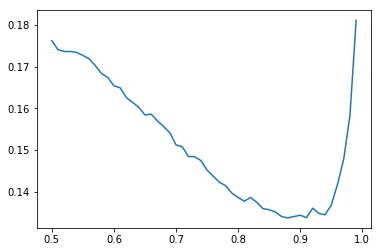

Score sur le train : 0.133695947784
Running Time:  1403.301607


In [29]:
import time
start = time.clock()
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
clf = XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=10,min_child_weight=1,gamma=0,subsample=0.8,
                     colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
clf.fit(X_train_split, y_train_split)
y_inter = clf.predict_proba(X_test_split)

# To select a best Threshold:
score_min = 1
threshold = 0.7
score = np.zeros(50)
i=0
plt.figure()
for x in np.linspace(0.5, 0.99, num=50):
    y_pred_train = predict(y_inter,x)
    score[i] = compute_pred_score(y_test_split, y_pred_train)
    if score[i] < score_min:
        score_min = score[i]
        threshold = x
    print('Threshold %s \t Score : %s' %(x,score[i]))
    i=i+1
plt.plot(np.linspace(0.5, 0.99, num=50),score)
plt.show()

# Play with the best threshold
y_pred_train = predict(y_inter,threshold)
score = compute_pred_score(y_test_split, y_pred_train)
print('Score sur le train : %s' % score)
end = time.clock()
print "Running Time: ",end-start

In [30]:
import time
start = time.clock()
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
clf = XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=10,min_child_weight=1,gamma=0,subsample=0.8,
                     colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
clf.fit(X_train_pca, y_train_unique)
y_inter = clf.predict_proba(X_test_pca)

# Play with the best threshold
y_pred = predict(y_inter,0.88)
np.savetxt('y_pred_xgboost.txt', y_pred, fmt='%d')
end = time.clock()
print "Running Time: ",end-start

Running Time:  2346.601565


In [22]:
import time
start = time.clock()
y_pred = predict(y_inter,0.76)
np.savetxt('y_pred_xgboost.txt', y_pred, fmt='%d')
end = time.clock()
print "Running Time: ",end-start

Running Time:  0.0333099999998


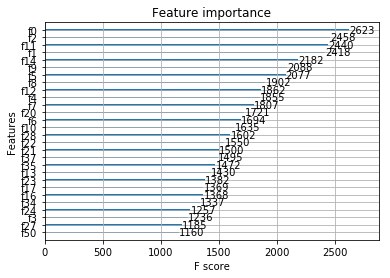

In [34]:
from xgboost import plot_importance
plot_importance(clf, max_num_features=28)

In [35]:
import lightgbm as lgb
from lightgbm import plot_importance
plot_importance(clf, max_num_features=28)

ImportError: No module named lightgbm